# Time Frequency Representations

In [135]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

data_dir = "/Users/martin.iniguez/Desktop/master-thesis/opm-thesis/data/digits_epochs/"
file = data_dir + "freq_bands/all_data_all_epochs.pkl"
all_epochs = pickle.load(open(file, "rb")).pick(picks="meg", exclude="bads")
all_epochs = all_epochs.decimate(2)

In [137]:
all_epochs

Number of events,388
Events,press_1: 78press_2: 76press_3: 77press_4: 79press_5: 78
Time range,-2.000 – 2.000 s
Baseline,-2.000 – -0.582 s


## Calculate TFR

In [2]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 5
fmax = 60
freqs = np.arange(fmin, fmax + 1, 3)
n_cycles = freqs / 2  # different number of cycle per frequency

if os.path.exists(data_dir + "all_epochs_tfr.pkl"):
    with open(data_dir + "all_epochs_tfr.pkl", "rb") as f:
        power = pickle.load(f)
else:

    power = {}
    for idx, label in enumerate(labels):
        valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
        label_epochs = all_epochs[valid_epochs_mask]

        power[idx + 1] = mne.time_frequency.tfr_morlet(
            label_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=1,
            return_itc=False,
            decim=3,
        )
    with open(data_dir + "all_epochs_tfr.pkl", "wb") as f:
        pickle.dump(power, f)

if os.path.exists(data_dir + "individual_epoch_tfr.pkl"):
    with open(data_dir + "individual_epoch_tfr.pkl", "rb") as f:
        power_per_epoch = pickle.load(f)

else:
    power_per_epoch = mne.time_frequency.tfr_morlet(
            all_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=5,
            return_itc=False,
            decim=3,
            average=False,
        )
    with open(data_dir + "individual_epoch_tfr.pkl", "wb") as f:
        pickle.dump(power_per_epoch, f)



### Plot TFR on different states

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


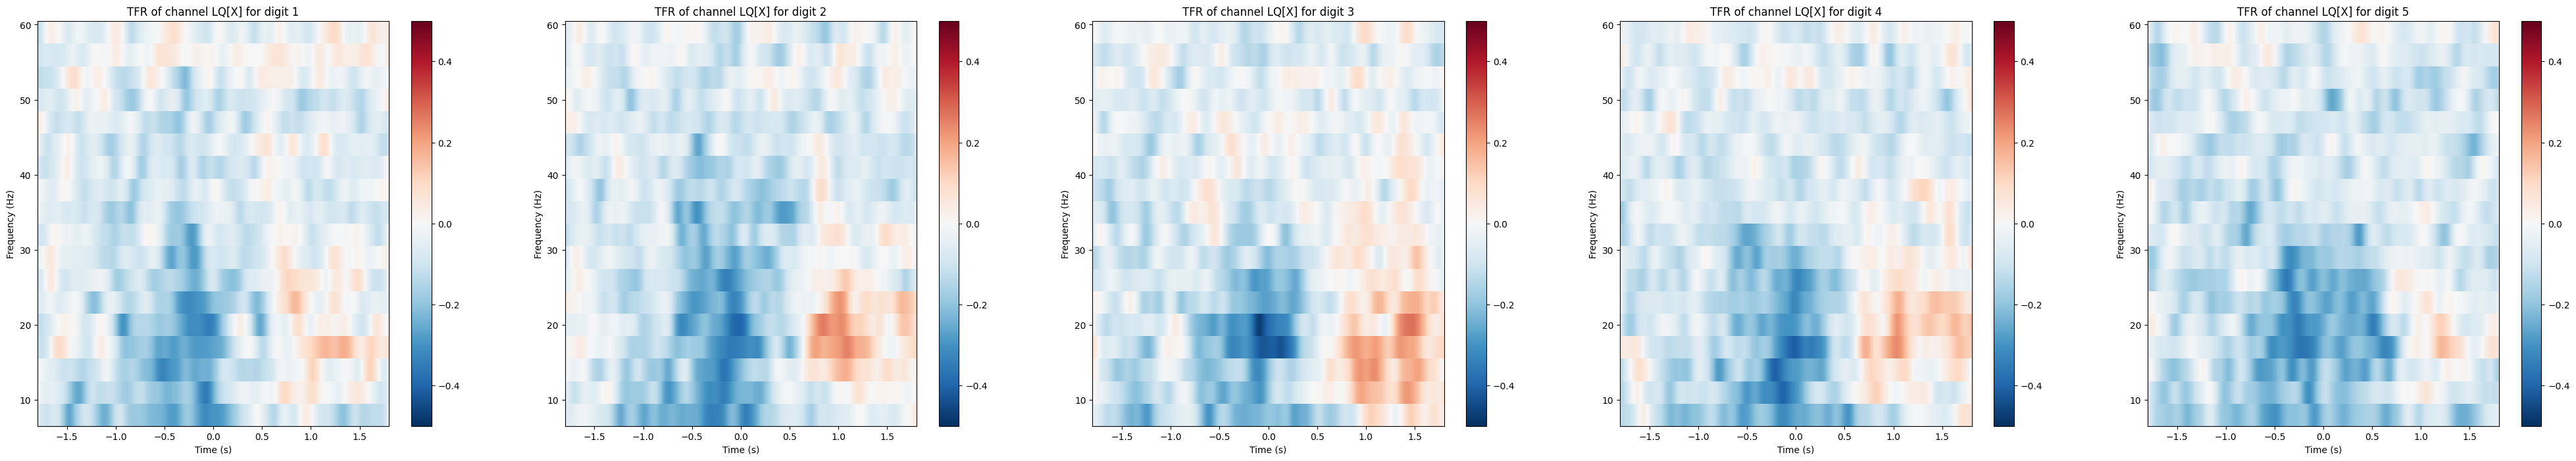

In [3]:
center_channel = "LQ[X]"
idx_channel = all_epochs.ch_names.index(center_channel)

conditions = [1, 2, 3, 4, 5]

# Create a figure with subplots
fig, axes = plt.subplots(
    1, len(conditions), figsize=(50, 8)
)  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]

    # Plot the 5 different digits in a subplot horziontally
    power[i + 1].plot(
        [idx_channel],
        baseline=(-2, -0.57),
        mode="logratio",
        tmin=-1.8,
        tmax=1.8,
        axes=ax,
        show=False,
        vmin=-0.5,
        vmax=0.5,
    )
    ax.set_title("TFR of channel " + center_channel + " for digit " + str(i + 1))

### Creating figure of frequency importance

In [88]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 2
fmax = 45
freqs = np.arange(fmin, fmax + 1, 1)
n_cycles = freqs / 2  # different number of cycle per frequency

power_small_scale = {}

if os.path.exists(data_dir + "all_epochs_tfr_small_scale.pkl"):
    with open(data_dir + "individual_epoch_tfr.pkl", "rb") as f:
        power_small_scale = pickle.load(f)

else:
    for idx, label in enumerate(labels):
        valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
        label_epochs = all_epochs[valid_epochs_mask]

        power_small_scale[idx + 1] = mne.time_frequency.tfr_morlet(
            label_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            picks=idx_channel,
            n_jobs=1,
            return_itc=False,
            decim=3,
        )
    with open(data_dir + "all_epochs_tfr_small_scale.pkl", "wb") as f:
        pickle.dump(power_small_scale, f)


if os.path.exists(data_dir + "individual_epoch_tfr_small_scale.pkl"):
    with open(data_dir + "individual_epoch_tfr.pkl", "rb") as f:
        power_per_epoch = pickle.load(f)

else:
    power_per_epoch_small_scale = mne.time_frequency.tfr_morlet(
        all_epochs,
        freqs=freqs,
        picks=idx_channel,
        n_cycles=n_cycles,
        n_jobs=5,
        return_itc=False,
        decim=3,
        average=False,
    )
    with open(data_dir + "individual_epoch_tfr_small_scale.pkl", "wb") as f:
        pickle.dump(power_per_epoch_small_scale, f)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Not setting metadata


### Rescaling power


In [81]:
from mne.baseline import rescale

power_scaled = []
integrated_power = []

for i in range(5):
    data = power_small_scale[i + 1].data[0]
    times = power_small_scale[i + 1].times
    baseline = (-2, -0.57)
    data = rescale(data, times, baseline, mode="logratio")
    if np.iscomplexobj(data):
        data = (data * data.conj()).real
    time_indices = np.where((times >= -1.75) & (times <= 1.75))[0]
    times = times[time_indices]
    power_scaled.append(data[:, time_indices])

    time_idx = np.where((times >= 0.75) & (times <= 1.75))[0]
    integrated_power.append(np.mean(power_scaled[i][:, time_idx], axis=1))


power_scaled = np.array(power_scaled)
variance = np.var(power_scaled[:], axis=2)
mean = np.mean(power_scaled[:], axis=2)

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


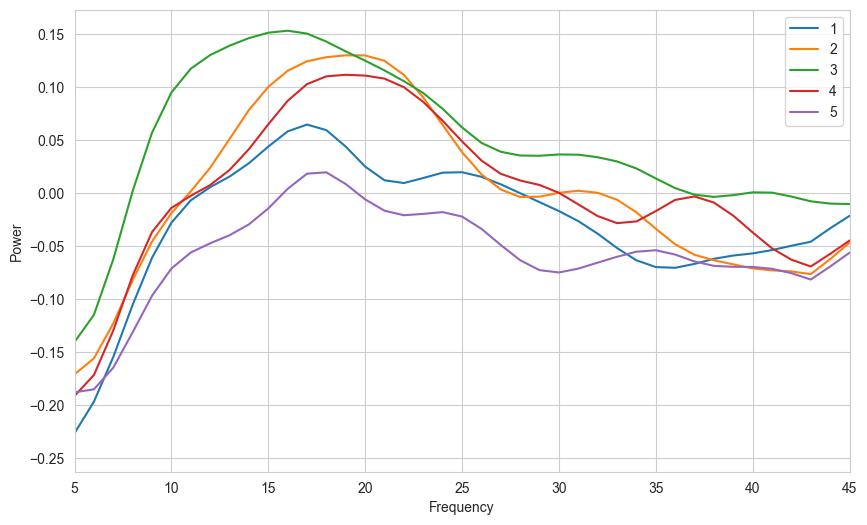

In [132]:
import seaborn as sns
import pandas as pd

data_list = []

sns.set_style("whitegrid")

# Create the line plot with confidence interval
plt.figure(figsize=(10, 6))
num = 0

# Plot the lineplot of all digits
for power in integrated_power:
    # Do a low pass filter of the power np.array
    power = np.convolve(power, np.ones(5), "same") / 5
    df = pd.DataFrame({"Power":power})
    df["Frequency"] = freqs
    num += 1
    lineplot = sns.lineplot(
        data=df,
        x="Frequency",
        y="Power",
        label=num,
    )
    xlim = (5, 45)
    lineplot.set(xlim=xlim)
    # Add legend
lineplot.legend()
plt.show()

### Rescaling power per epoch

In [108]:
from mne.baseline import rescale

power_scaled_per_epoch = []
integrated_power_per_epoch = {
    8: [],
    16: [],
    32: [],
    64: [],
    128: [],
}

for i in range(len(power_per_epoch_small_scale) - 1):
    data = power_per_epoch_small_scale[i].data[0, 0]
    times = power_per_epoch_small_scale[i].times
    baseline = (-2, -0.57)
    data = rescale(data, times, baseline, mode="logratio", verbose=False)
    if np.iscomplexobj(data):
        data = (data * data.conj()).real
    time_indices = np.where((times >= -1.75) & (times <= 1.75))[0]
    times = times[time_indices]
    power_scaled_per_epoch.append(data[:, time_indices])

    time_idx = np.where((times >= 0.75) & (times <= 1.75))[0]
    integrated_power_per_epoch[all_epochs.events[i,-1]].append(
        np.mean(power_scaled_per_epoch[i][:, time_idx], axis=1)
    )

for key in integrated_power_per_epoch.keys():
    integrated_power_per_epoch[key] = np.array(integrated_power_per_epoch[key])

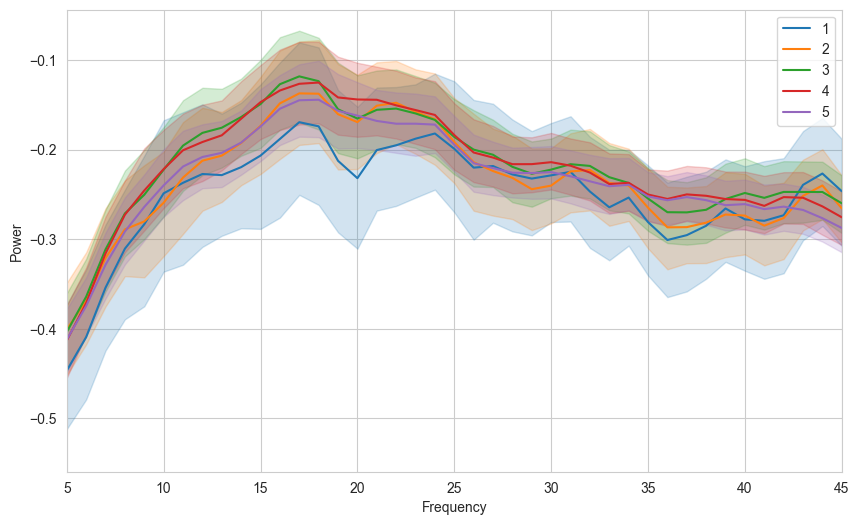

In [134]:
import seaborn as sns
import pandas as pd

data_list = []

sns.set_style("whitegrid")

# Create the line plot with confidence interval
plt.figure(figsize=(10, 6))
num = 0

# Plot the lineplot of all digits
for key in integrated_power_per_epoch.keys():
    for epoch in range(integrated_power_per_epoch[key].shape[0]):
        for freq_index in range(integrated_power_per_epoch[key].shape[1]):
            data_list.append(
                {
                    "Epoch": epoch,
                    "Frequency": freqs[freq_index],
                    "Power": integrated_power_per_epoch[key][epoch, freq_index],
                }
            )
    power_df = pd.DataFrame(data_list)
    num += 1
    lineplot = sns.lineplot(
        data=power_df, x="Frequency", y="Power", label=num, estimator="mean"
    )
    xlim = (5, 45)
    lineplot.set(xlim=xlim)
    # Add legend
lineplot.legend()

In [7]:
power_scaled.shape

(5, 167, 699)

## Creating a classifier

In [91]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from opm_thesis.classifiers.classifier import TimeFreqCNN, MyDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

labels_to_use = [32, 128]
labels = all_epochs.events[:, -1]

valid_epochs_mask = np.isin(labels, labels_to_use)
data = power_per_epoch.data[valid_epochs_mask]
labels = labels[valid_epochs_mask]

label_mapping = {label: idx for idx, label in enumerate(labels_to_use)}
# Map the labels to 0 and 1
final_targets = np.array(
    [label_mapping[label] for label in labels if label in label_mapping]
)

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, final_targets, test_size=0.2, random_state=42
)

# Create PyTorch datasets and loaders
train_dataset = MyDataset(train_data, train_labels)
test_dataset = MyDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Train the classifier and evaluate it
classifier = TimeFreqCNN(
    len(labels_to_use), data.shape[1], data.shape[2], data.shape[3], device
)
classifier.train_model(train_loader, num_epochs=20, learning_rate=1e-3)
classifier.evaluate(test_loader)*100

KeyboardInterrupt: 

In [92]:
power_per_epoch_labelled = {}
labels = np.unique(all_epochs.events[:, -1])

for idx, label in enumerate(labels):
    valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
    power_per_epoch_labelled[idx] = power_per_epoch[valid_epochs_mask]

## Finding significant differences between TFR plots

In [81]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

t_test_results = {}

# Perform t-tests between each pair of conditions
for condition1 in range(1, 6):
    for condition2 in range(condition1 + 1, 6):
        # Compute the t-test on the two independent samples
        t_stat, p_value = ttest_ind(
            power[condition1].data, power[condition2].data, axis=0
        )

        # Apply multiple comparisons correction using FDR
        p_value_reshaped = p_value.flatten()
        reject, p_value_corrected, _, _ = multipletests(
            p_value_reshaped, method="fdr_bh"
        )
        p_value_corrected_reshaped = p_value_corrected.reshape(p_value.shape)

        # Store the corrected p-values and t-statistics
        t_test_results[(condition1, condition2)] = {
            "t_stat": t_stat,
            "p_value_corrected": p_value_corrected_reshaped,
        }

# Choose a significance level
alpha = 0.05

# Create a dictionary to store whether each test is significant
significant_results = {}

# Check for significance and store the results
for key, result in t_test_results.items():
    significant_mask = result["p_value_corrected"] < alpha
    significant_results[key] = significant_mask

for condition_pair, mask in significant_results.items():
  num_significant_points = np.sum(mask)
  print(f"Condition pair {condition_pair} has {num_significant_points} significant points after correction.")

Condition pair (1, 2) has 0 significant points after correction.
Condition pair (1, 3) has 0 significant points after correction.
Condition pair (1, 4) has 0 significant points after correction.
Condition pair (1, 5) has 0 significant points after correction.
Condition pair (2, 3) has 0 significant points after correction.
Condition pair (2, 4) has 0 significant points after correction.
Condition pair (2, 5) has 0 significant points after correction.
Condition pair (3, 4) has 0 significant points after correction.
Condition pair (3, 5) has 764 significant points after correction.
Condition pair (4, 5) has 0 significant points after correction.


### Plot the significant points

https://tsfresh.readthedocs.io/en/latest/
Jesus Cortes1:58 PM
https://github.com/benfulcher/hctsa

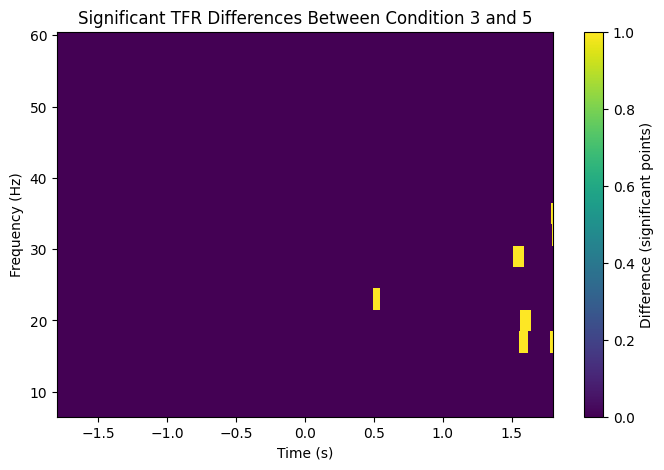

In [82]:
plt.figure(figsize=(8, 5))
index_center_channel = power[3].ch_names.index(center_channel)

significant_mask = significant_results[(3, 5)]
difference_tfr = (
    power[3].data[index_center_channel] - power[5].data[index_center_channel]
)
masked_difference_tfr = np.ma.array(difference_tfr, mask=~significant_mask)
time = np.linspace(-2, 2, difference_tfr.shape[1])
frequency = np.arange(difference_tfr.shape[0])
T, F = np.meshgrid(time, freqs)
plt.pcolormesh(T, F, significant_mask, shading="auto")
plt.colorbar(label="Difference (significant points)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Significant TFR Differences Between Condition 3 and 5")
plt.xlim(-1.8, 1.8)
plt.show()

## TFR all brain


In [83]:
from opm_thesis.preprocessing.utils import get_closest_sensors

closest_sensors = get_closest_sensors(all_epochs.info, center_channel, num_channels=20)
idx_closest_sensors = [all_epochs.ch_names.index(sensor) for sensor in closest_sensors]

closest_sensors_x = [
    all_epochs.ch_names.index(sensor) for sensor in closest_sensors if "X" in sensor[-2]
]
closest_sensors_y = [
    all_epochs.ch_names.index(sensor) for sensor in closest_sensors if "Y" in sensor[-2]
]
closest_sensors_z = [
    all_epochs.ch_names.index(sensor) for sensor in closest_sensors if "Z" in sensor[-2]
]

labels = np.unique(all_epochs.events[:, -1])
fmin = 8
fmax = 60
freqs = np.arange(fmin, fmax + 1, 3)
n_cycles = freqs / 2  # different number of cycle per frequency

if os.path.exists(data_dir + "all_epochs_tfr_closest_sensors.pkl"):
    with open(data_dir + "all_epochs_tfr_closest_sensors.pkl", "rb") as f:
        power_closest_sensors = pickle.load(f)

else:
      power_closest_sensors = {}
      for idx, label in enumerate(labels):
          valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
          label_epochs = all_epochs[valid_epochs_mask]
          label_epochs = label_epochs.pick(picks=closest_sensors_x)

          power_closest_sensors[idx + 1] = mne.time_frequency.tfr_morlet(
              label_epochs,
              freqs=freqs,
              n_cycles=n_cycles,
              n_jobs=1,
              return_itc=False,
              decim=3,
          )
      with open(data_dir + "all_epochs_tfr_closest_sensors_x.pkl", "wb") as f:
          pickle.dump(power_closest_sensors, f)

In [93]:
for i, condition in enumerate(np.arange(1, 6)):
  mne.viz.plot_tfr_topomap(
    power_closest_sensors[i+1],
    tmin=-1.8,
    tmax=1.8,
    ch_type="mag",
    baseline=(-2, -0.57),
    mode="logratio",
    vlim = (-0.75,0.75)
  )
plt.show()

AttributeError: module 'mne.viz' has no attribute 'plot_topo'

Try https://mne.tools/0.22/auto_examples/visualization/plot_evoked_topomap.html

Applying baseline correction (mode: logratio)


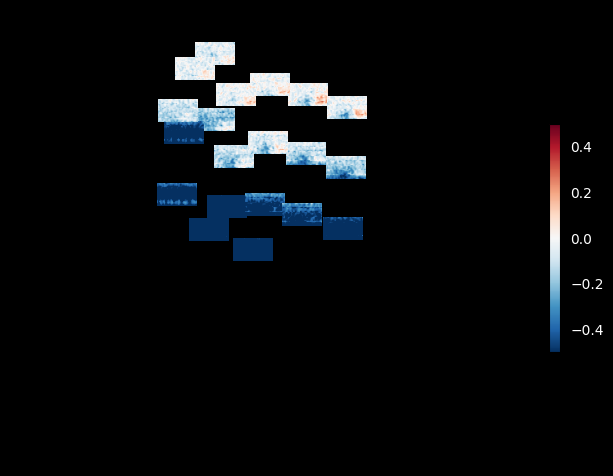

In [105]:
power[i + 1].plot_topo(
        closest_sensors_x,
        baseline=(-2, -0.57),
        mode="logratio",
        tmin=-1.8,
        tmax=1.8,
        show=False,
        vmin=-0.5,
        vmax=0.5,
        layout_scale= 1.5,
    )
plt.show()